## Metpy cape

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Seaborn enhances the aesthetics of matplotlib plots
import pandas as pd
import xarray as xr
import random 

from tempest import casestudy
from tempest import grid
from tempest import storm_tracker
from tempest import handler
from tempest import joint_distrib

from tempest.plots.hist import simple_hist
settings_path = 'settings/sam3d.yaml'

In [4]:
# Instantiate CaseStudy by passing the settings. 
# Should also create appropriate directories
hdlr = handler.Handler(settings_path)
cs = casestudy.CaseStudy(hdlr, overwrite = False ,verbose = False)
st = storm_tracker.StormTracker(cs, overwrite_storms = False, overwrite = False, verbose = True) #overwrite = True is super long, computes growth rate (triangle fit)

Data loaded from /homedata/mcarenso/shear/SAM3d_Tropics/var_id_days_i_t.json
Loading storms...
loading storms from netcdf
Time elapsed for loading storms: 1.10 seconds


In [125]:
import metpy.calc as mpcalc
from metpy.calc import dewpoint_from_specific_humidity, mixed_parcel
from metpy.units import units

sel_dict = {'lat': slice(9.63, 18.15, None), 'lon': slice(179.0, 187.67, None)}
# Assuming 'PP', 'QV', and 'TABS' are arrays from your data
i_t = 1824
PP = hdlr.load_var(cs, "PP", i_t, z_idx = "all", sel_dict = sel_dict).isel(time=0)
QV = hdlr.load_var(cs, "QV", i_t, z_idx = "all", sel_dict = sel_dict).isel(time=0)
TABS = hdlr.load_var(cs, "TABS", i_t, z_idx = "all", sel_dict = sel_dict).isel(time=0)

In [126]:
pressure = (PP.PP + 100*PP.p) * units.Pa
specific_humidity  = QV.QV * units('g/kg')
temperature = TABS.TABS*units.K 
dewpoint = dewpoint_from_specific_humidity(pressure, temperature, specific_humidity)

In [127]:
# Prepare empty DataArrays for CAPE and CIN without a time dimension since we're only working with one timestep
cape_da = xr.DataArray(np.empty((temperature.lat.size, temperature.lon.size)), 
                       coords=[temperature.lat, temperature.lon], 
                       dims=['lat', 'lon'], 
                       name="CAPE")
cin_da = xr.DataArray(np.empty((temperature.lat.size, temperature.lon.size)), 
                      coords=[temperature.lat, temperature.lon], 
                      dims=['lat', 'lon'], 
                      name="CIN")

# Iterate over each lat and lon for the selected time step
for lat in temperature.lat:
    for lon in temperature.lon:
        # Extract the profile for the current grid point
        temp_profile = temperature.sel(lat=lat, lon=lon).metpy.convert_units('degC')
        dewpoint_profile = dewpoint.sel(lat=lat, lon=lon)
        pressure_profile = pressure.sel(lat=lat, lon=lon)
        
        # Calculate CAPE and CIN for the profile
        cape, cin = mpcalc.surface_based_cape_cin(pressure_profile, temp_profile, dewpoint_profile)
        
        # Store the results in the DataArrays
        cape_da.loc[dict(lat=lat, lon=lon)] = cape.magnitude
        cin_da.loc[dict(lat=lat, lon=lon)] = cin.magnitude

/net/nfs/tools/u20/Python/miniconda3_py310_22.11.1-1/envs/pangeo-meso-2023.04.15/lib/python3.10/site-packages/metpy/interpolate/one_dimension.py:142: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


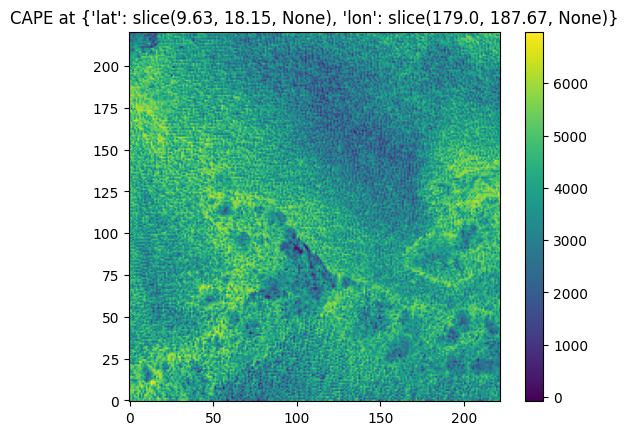

In [131]:
plt.imshow(cape_da, origin = "lower")
plt.title("CAPE at " + str(sel_dict))
plt.colorbar()

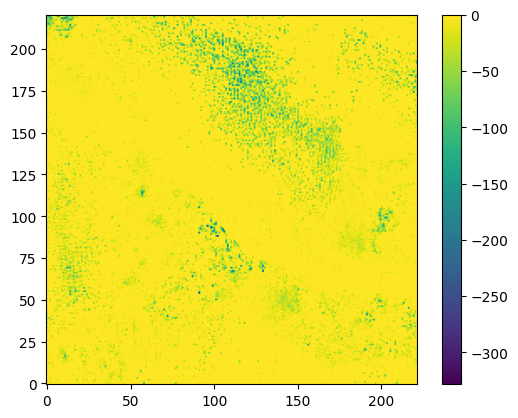

In [132]:
plt.imshow(cin_da, origin = "lower")
plt.colorbar()

In [70]:
# Compute CAPE and CIN for a surface parcel
cape_surface, cin_surface = mpcalc.cape_cin(pressure, temperature, dewpoint, parcel_profile='surface')

# Compute CAPE and CIN for a mean layer parcel (e.g., lowest 100 hPa)
mean_pressure, mean_temperature, mean_dewpoint = mixed_parcel(pressure, temperature, dewpoint, depth=100 * units.hPa)
cape_mean_layer, cin_mean_layer = mpcalc.cape_cin(pressure, temperature, dewpoint, parcel_profile='mixed_layer')

# Display results
print(f"Surface Parcel CAPE: {cape_surface:.2f}, CIN: {cin_surface:.2f}")
print(f"Mean Layer Parcel CAPE: {cape_mean_layer:.2f}, CIN: {cin_mean_layer:.2f}")

ValueError: This function changed in 1.0--double check that the function is being called properly.
`cape_cin` given arguments with incorrect units: `parcel_profile` requires "[temperature]" but given "none"
A xarray DataArray or numpy array `x` can be assigned a unit as follows:
    from metpy.units import units
    x = x * units("m/s")
For more information see the Units Tutorial: https://unidata.github.io/MetPy/latest/tutorials/unit_tutorial.html

In [5]:
type(int(1.))== int

True